In [1]:
# import dependencies
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
import colorsys
from PIL import Image

import requests
from io import BytesIO

from base64 import b64encode, b64decode

%matplotlib inline

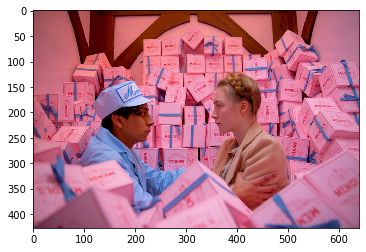

In [2]:
# import example image
filename = 'images/GBH.jpg'

img = Image.open(filename)
plt.imshow(img)

# keep copy of original image for later
img_orig = img.copy()

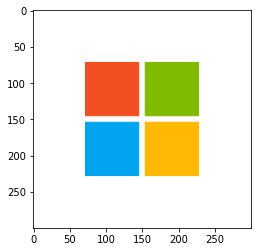

In [3]:
# can also import image from URL
url = 'https://images.squarespace-cdn.com/content/v1/5dc1ccd7e0292e070ef93a24/1573168875122-MSBE2YRFS1R3UIEPK3LZ/ke17ZwdGBToddI8pDm48kL6Gv8ZO6JV7Z4ifWuMgNDp7gQa3H78H3Y0txjaiv_0fDoOvxcdMmMKkDsyUqMSsMWxHk725yiiHCCLfrh8O1z5QPOohDIaIeljMHgDF5CVlOqpeNLcJ80NK65_fV7S1UfwSeTrjJXgRaFvmKmLknDKbcrwOXCbPKyMoGFGIZIboOpYghpI-Ha_TwZsqqmJXng/Stormboard+and+Microsoft-Logo?format=300w'

response = requests.get(url)
img = Image.open(BytesIO(response.content))

plt.imshow(img)

# keep copy of original image for later
img_orig = img.copy()

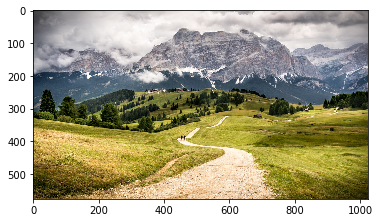

In [4]:
# can also manage images coming in as base64 text, e.g. from a javascript API
with open("images/landscape.jpg", "rb") as image_file:
    img_b64 = b64encode(image_file.read())
    
img = Image.open(BytesIO(b64decode(img_b64)))

img_orig = img.copy()

plt.imshow(img)

In [5]:
# resize image to keep size relatively small and keep calculations running quickly
basewidth = 100
wpercent = (basewidth / float(img.size[0]))
hsize = int((float(img.size[1]) * float(wpercent)))
img = img.resize((basewidth, hsize), Image.ANTIALIAS)

In [6]:
# get channels and turn colours into dataframe columns
arr = np.array(img.convert('RGB')) # need .convert('RGB') as sometimes png may not be loaded as such

r = arr[:,:,0].flatten()
g = arr[:,:,1].flatten()
b = arr[:,:,2].flatten()

rgb = np.column_stack((r,g,b)) 

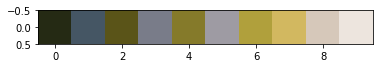

In [7]:
# pick how many colours will populate our palette, then perform a KMeans, and finally get the centroids identifying the colours we will display
n_clusters = 10

kmeans = KMeans(n_clusters=n_clusters).fit(rgb)

centroids = np.unique(kmeans.cluster_centers_, axis=0)

plt.imshow([centroids/255])

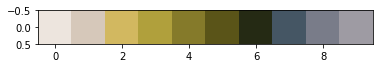

In [8]:
# for a more visually appealing palette, let's order the colours by hue
colours = []
for row in range(len(centroids)):

    c = list(centroids[row,:]/255)

    colours.append(list(colorsys.rgb_to_hsv(*c)))
    
colours.sort()

colours = [list(colorsys.hsv_to_rgb(*c)) for c in colours]

plt.imshow([np.array(colours)])

In [9]:
# Let's create a new image that will work as a canvas to display input image and palette
full_w = 1000
full_h = 1000

new_img = Image.new('RGBA', (full_w, full_h), "white")

#
frame_s = round(full_w / 60)

intrabox_w = round(full_w / 100)

box_w = round((full_w - ((frame_s*2) + (intrabox_w*(n_clusters-1)))) / n_clusters)
box_h = round(full_h / 4)

x = frame_s
for col in colours:

    col_box = Image.new('RGBA', (box_w, box_h), tuple(np.round(np.array(col)*255).astype(int)))

    new_img.paste(col_box, (x, full_h-frame_s-box_h))

    x = x + box_w + intrabox_w

#
basewidth = round(full_w - (frame_s*2))
baseheight = round(full_h - (frame_s + box_h) - (full_h/10*2))

# adjust height to fit box
wpercent = (baseheight / float(img_orig.size[1]))
wsize = int((float(img_orig.size[0]) * float(wpercent)))
img_orig = img_orig.resize((wsize, baseheight), Image.ANTIALIAS)

# if width still not fitting, also adjust that
if img_orig.size[0] > basewidth:
    wpercent = (basewidth / float(img_orig.size[0]))
    hsize = int((float(img_orig.size[1]) * float(wpercent)))
    img_orig = img_orig.resize((basewidth, hsize), Image.ANTIALIAS)

#
wsize = img_orig.size[0]
hsize = img_orig.size[1]

pos_x = frame_s + round((basewidth-wsize)/2)
pos_y = round(full_h/10) + round((baseheight-hsize)/2)

coords = (pos_x, pos_y)

new_img.paste(img_orig, coords)

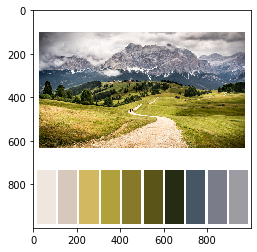

In [10]:
plt.imshow(new_img)
new_img.save("output/"+filename.split('/')[-1].split('.')[0]+"_palette.png", "PNG")

In [11]:
# if needed, can encode the image back to base64
buffered = BytesIO()
new_img.save(buffered, format="PNG")
img_str = b64encode(buffered.getvalue()).decode('utf-8')

print(img_str[:50])

iVBORw0KGgoAAAANSUhEUgAAA+gAAAPoCAYAAABNo9TkAAEAAE
